# <u>Analysis of Orchestral Performance Trends (Last 150 Years)</u>

## Overview

As a former classical musician entering the data science field, I thought it would be really interesting to see how orchestral music has evolved over the many years it's been performed. Given that so much of the great symphonic music has only been composed in the last 100-150 years, it will be interesting to see how the popularity of certain repertoire ebbed and flowed, as did certain composers and certain conductors. 

Having previously seen a post by _ who did an analysis on performance records by the New York Philharmonic, I knew that they had a digital archive from which the records could be obtainable. After going through almost every other major orchestra's website to see if there was any publically available data for us to scrape or access directly, I found that the Boston Symphony also kept performance archives from which we could pull data from.

Ideally, we would have data from numerous sources, but I think we should be able to learn a great deal from just these two sources. Let's dig in!

## Obtaining the Data

#### New York Philharmonic Data

As previously mentioned, they have made available all performance records to the public, and have gone so far as to put a JSON on github from which we can directly pull data. This makes my work much simpler!

https://raw.githubusercontent.com/nyphilarchive/PerformanceHistory/master/Programs/json/complete.json

#### Boston Symphony Orchestra Data

The Boston Symphony Orchestra has not made their data available through github, but does have a portal from which you can search for composers, or works during a specified time. They have very generously provided a way to even download the csv, which we will not use though. Below is the image of the search function.

https://archives.bso.org/

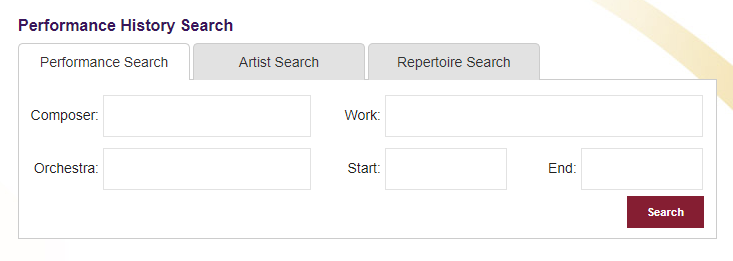

Even for webscraping, it would be quite tedious to continually enter dates in the search toolbar, and then continually navigate through links of each performance page as well as paginate to the rest of the performances. Fortunately, each page is uniquely identified by a 5 digit ID number and so looping through all 5 digit numbers containing the beginning of each link would get us all of the data that we need in a much more efficient manner. Even more helpful is the fact that for any scraping that would require us to input text information in a search bar, we would need a scraped that could pages with javascript (such as Splash or Selenium) which would further increase both time and processing costs. 

Through Scrapy with Python, I was able to go through 89,999 links in a matter of 30 minutes. With Splash or Selenium, this process could have taken more than 20 hours. I have provided the Scrapy script in the github. It's fairly straightforward but feel free to drop me a line if there is any confusion. Of course, the data is provided in the GitHub so you don't need to bother scraping it if you are interesting in taking a closer look for yourself

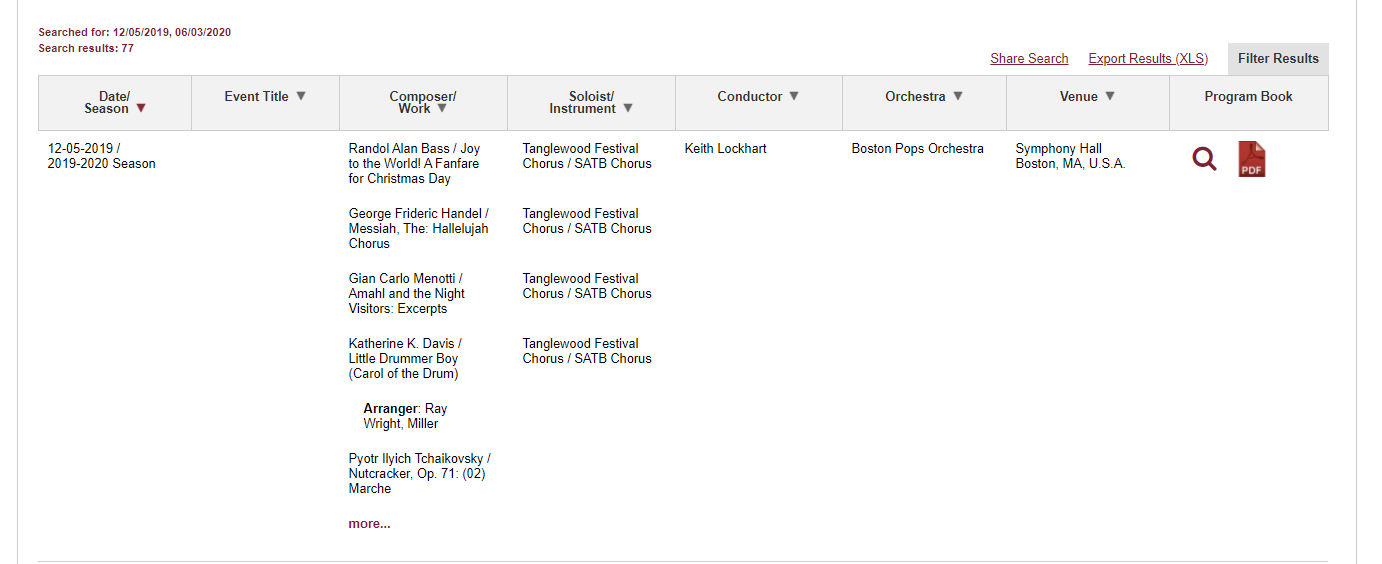

To get full details, we need to press more button which adds complexity if we choose to scrape using search function


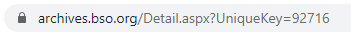

Link Unique ID Code

Now that we have all the data, let's get to it!

### Import packages

In [4]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt

## Preprocessing

Of course, we need to process the jsons into panda dataframes that we can work with. Dates and times need to be converted into DateTime format. And some general standardizing of both dataframes so their variables and the format of the data is the same between the two. 

We will have to versions of each dataframe: One with each row being one individual performance, and one row containing just one piece (a performance likely having multiple pieces). Given that I scraped the Boston data myself, the processing will not take too long. With the New York data however, it is a bit convoluted...

In [5]:
### This may take a few minutes!

nyp = pd.read_json('https://raw.githubusercontent.com/nyphilarchive/PerformanceHistory/master/Programs/json/complete.json')
programs = nyp.loc[:, 'programs']

In [6]:
### NYP Dataframe (Each row containing only one performace)

ID = []
orchestra = []
programID = []
season = []
eventType = []
Location = []
Venue = []
Date = []
Time = []

WorksID = []
ComposerName = []
WorkTitle = []
ConductorName = []
Soloists = []

for row in programs:
    worksID = []
    composerName = []
    workTitle = []
    conductorName = []
    soloists = []
    
    for work in row['works']:
        worksID.append(work['ID'])  
        composerName.append(work.get('composerName', 'NA'))
        workTitle.append(work.get('workTitle', 'No work apparently'))
        conductorName.append(work.get('conductorName', 'No conductor'))
        soloists.append(work.get('soloists', 'No soloists'))
            
    WorksID.append(worksID)
    ComposerName.append(composerName)
    WorkTitle.append(workTitle)
    ConductorName.append(conductorName)
    Soloists.append(soloists)
        
    ID.append(row['id'])
    programID.append(row['programID'])
    season.append(row['season'])
    orchestra.append(row['orchestra'])
    eventType.append(row['concerts'][0]['eventType'])
    Location.append(row['concerts'][0]['Location'])
    Venue.append(row['concerts'][0]['Venue'])
    Date.append(row['concerts'][0]['Date'])
    Time.append(row['concerts'][0]['Time'])
    
data = {'Orchestra': orchestra, 
        'programID':programID, 
        'Season': season, 
        'Location':Location, 
        'eventType': eventType, 
        'Hall': Venue, 
        'Date': Date, 
        'Time': Time, 
        'WorksID': WorksID, 
        'composerName': ComposerName,
        'WorkTitle': WorkTitle,
        'conductorName': ConductorName,
        'Soloists': Soloists
       } 

newyork_df = pd.DataFrame(data, index = ID)

#Converting into Date Fromat

#newyork_df["Date and Time"] = newyork_df['Date'].str[:10] + ':' + newyork_df['Time']
#newyork_df['Date and Time'] = pd.to_datetime(newyork_df['Date and Time'], format = "%Y-%m-%d:%I:%M%p", errors = 'ignore')

#newyork_df = pd.to_datetime(newyork_df['Date and Time'], format = "%Y-%m-%dT05:00:00Z:%I:%M%p", errors = 'ignore')

#newyork_df['Time'] = pd.to_datetime(newyork_df['Time'], format = '%I:%M%p', errors = 'ignore')
newyork_df['Date'] = pd.to_datetime(newyork_df['Date'].str[:10], format = '%Y-%m-%d')
newyork_df['Year'] = newyork_df['Date'].apply(lambda x: x.year)
newyork_df['Month'] = newyork_df['Date'].apply(lambda x: x.month)

def convert_time(x):
    try:
        return datetime.datetime.strptime(x, '%I:%M%p')
    except:
        return None
newyork_df['Time'] = newyork_df['Time'].apply(convert_time)

#return date.replace(hour=11, minute=59)

newyork_df.head()

,Orchestra,programID,Season,Location,eventType,Hall,Date,Time,WorksID,composerName,WorkTitle,conductorName,Soloists,Year,Month
00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,New York Philharmonic,3853,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07,1900-01-01 20:00:00,"[52446*, 8834*4, 3642*, 0*, 8834*3, 8835*1, 88...","[Beethoven, Ludwig van, Weber, Carl Maria ...","[SYMPHONY NO. 5 IN C MINOR, OP.67, OBERON, QUI...","[Hill, Ureli Corelli, Timm, Henry C., No condu...","[[], [{'soloistName': 'Otto, Antoinette', 'sol...",1842,12
1118e84e-eb59-46cc-9119-d903375e65e6-0.1,New York Philharmonic,5178,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1843-02-18,1900-01-01 20:00:00,"[52437*, 8838*2, 3659*, 0*, 8839*2, 53076*2, 5...","[Beethoven, Ludwig van, Bellini, Vincenzo, ...","[SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROIC...","[Hill, Ureli Corelli, Hill, Ureli Corelli, Hil...","[[], [{'soloistName': 'Otto, Antoinette', 'sol...",1843,2
08536612-27c3-437e-9b44-def21034b06c-0.1,Musicians from the New York Philharmonic,10785,1842-43,"Manhattan, NY",Special,Apollo Rooms,1843-04-07,1900-01-01 20:00:00,"[52364*1, 8834*4, 4567*, 5150*, 5161*, 5162*2,...","[Beethoven, Ludwig van, Weber, Carl Maria ...","[EGMONT, OP.84, OBERON, CONCERTO, PIANO, A MIN...","[Hill, Ureli Corelli, Not conducted, Hill, Ure...","[[], [{'soloistName': 'Otto, Antoinette', 'sol...",1843,4
81a3b8de-1737-4c9e-9318-b839f7c7c4c0-0.1,New York Philharmonic,5887,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1843-04-22,1900-01-01 20:00:00,"[52434*, 3666*, 5801*1, 0*, 52425*, 3674*, 507...","[Beethoven, Ludwig van, Haydn, Franz Josep...","[SYMPHONY NO. 2 IN D MAJOR, OP.36, SYMPATHY, H...","[Boucher, Alfred, Loder, George, Loder, George...","[[], [{'soloistName': 'Loder, Edward', 'solois...",1843,4
09581bb7-8855-4965-b302-fc54cc669041-0.1,New York Philharmonic,305,1843-44,"Manhattan, NY",Subscription Season,Apollo Rooms,1843-11-18,NaT,"[52453*, 3677*1, 0*, 8955*1, 5190*3, 50729*]","[Beethoven, Ludwig van, Nini, Alessandro, N...","[SYMPHONY NO. 7 IN A MAJOR, OP.92, IDA DELLA T...","[Hill, Ureli Corelli, Hill, Ureli Corelli, No ...","[[], [{'soloistName': 'Castellan, Jeanne Anais...",1843,11


In [33]:
### NYP Dataframe Flattened (Each row containing only one piece)

ID = []
orchestra = []
programID = []
season = []
eventType = []
Location = []
Venue = []
Date = []
Time = []

WorksID = []
ComposerName = []
WorkTitle = []
ConductorName = []
Soloists = []

for row in programs:
    for work in row['works']:
        ID.append(row['id'])
        orchestra.append(row['orchestra'])
        programID.append(row['programID'])
        season.append(row['season'])
        Location.append(row['concerts'][0]['Location'])
        eventType.append(row['concerts'][0]['eventType'])
        Venue.append(row['concerts'][0]['Venue'])
        Date.append(row['concerts'][0]['Date'])
        Time.append(row['concerts'][0]['Time'])
        WorksID.append(work['ID'])  
        ComposerName.append(work.get('composerName', 'NA'))
        WorkTitle.append(work.get('workTitle', 'No work apparently'))
        ConductorName.append(work.get('conductorName', 'No conductor'))
        Soloists.append(work.get('soloists', 'No soloists'))

data = {'Orchestra': orchestra, 
        'Season': season, 
        'Location':Location, 
        'eventType': eventType, 
        'Hall': Venue,
        'Date': Date,
        'Time':Time,
        'composerName': ComposerName,
        'WorkTitle': WorkTitle,
        'conductorName': ConductorName,
        'Soloists': Soloists,
        'WorksID': WorksID,
       } 

newyork_df_flat = pd.DataFrame(data, index = programID)

#Converting into Date Fromat
newyork_df_flat['Date'] = pd.to_datetime(newyork_df_flat['Date'], format = "%Y-%m-%dT%I:%M:%SZ")
newyork_df_flat['Year'] = newyork_df_flat['Date'].apply(lambda x: x.year)
newyork_df_flat['Month'] = newyork_df_flat['Date'].apply(lambda x: x.month)
newyork_df_flat['Work: Composer'] = newyork_df_flat['WorkTitle'].astype(str) + ': ' + newyork_df_flat['composerName']
newyork_df_flat.head()

,Orchestra,Season,Location,eventType,Hall,Date,Time,composerName,WorkTitle,conductorName,Soloists,WorksID,Year,Month,Work: Composer
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67","Hill, Ureli Corelli",[],52446*,1842,12,"SYMPHONY NO. 5 IN C MINOR, OP.67: Beethoven, ..."
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,"Weber, Carl Maria Von",OBERON,"Timm, Henry C.","[{'soloistName': 'Otto, Antoinette', 'soloistI...",8834*4,1842,12,"OBERON: Weber, Carl Maria Von"
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,"Hummel, Johann","QUINTET, PIANO, D MINOR, OP. 74",No conductor,"[{'soloistName': 'Scharfenberg, William', 'sol...",3642*,1842,12,"QUINTET, PIANO, D MINOR, OP. 74: Hummel, Johann"
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,NA,No work apparently,No conductor,[],0*,1842,12,No work apparently: NA
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,"Weber, Carl Maria Von",OBERON,"Etienne, Denis G.",[],8834*3,1842,12,"OBERON: Weber, Carl Maria Von"


#### Import Boston Data

In [7]:
### Boston DataFrame (One row for One Performance)

boston_df = pd.read_json('C:/Users/ujjaw/projects/bso/w6.json') 

#Converting into Date Fromat
boston_df['Season'] = boston_df['Season'].str[0:5] + boston_df['Season'].str[7:9]
boston_df['Date'] = pd.to_datetime(boston_df['Date'], format = "%Y-%m-%d")
boston_df['Year'] = boston_df['Date'].apply(lambda x: x.year)
boston_df['Month'] = boston_df['Date'].apply(lambda x: x.month)

#Converting into Time Format
def convert_time(x):
    try:
        return datetime.datetime.strptime(x, '%H:%M')
    except:
        return None
boston_df['Time'] = boston_df['Time'].apply(convert_time)

boston_df

,Orchestra,Date,Time,Season,Hall,Conductor,Composer,Work,Soloist,Year,Month
0,Boston Symphony Chamber Players,1974-02-17,1900-01-01 16:00:00,1973-74,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,"[Ludwig van Beethoven, Ludwig Spohr, Seymour S...","[Trio for Piano, Violin, and Celllo in G major...",[],1974,2
1,Boston Symphony Chamber Players,1973-02-04,1900-01-01 16:00:00,1972-73,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,"[Johann Sebastian Bach, William Sydeman, Carl ...","[Well-Tempered Clavier: Preludes and Fugues, a...",[],1973,2
2,Boston Symphony Chamber Players,1973-10-28,1900-01-01 16:00:00,1973-74,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,"[Camille Saint-Saëns, Charles Wuorinen, Walter...","[Fantaisie for violin and harp, Op. 124, Varia...",[],1973,10
3,Boston Symphony Chamber Players,1971-02-14,1900-01-01 16:00:00,1970-71,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,"[Wolfgang Amadeus Mozart, Wallingford Riegger,...",[Quartet for Piano and Strings No. 2 in E-flat...,[],1971,2
4,Boston Symphony Chamber Players,1973-03-11,1900-01-01 16:00:00,1972-73,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,"[Franz Joseph Haydn, Daniel Pinkham, Leo Kraft...","[Trio H.XVI:42 for strings in D major, Op. 53,...",[],1973,3
...,...,...,...,...,...,...,...,...,...,...,...
33155,BUTI Young Artists Vocal and Instrumental Prog...,1994-08-02,1900-01-01 15:45:00,1993-94,"Tanglewood - Shed, Lenox, MA, U.S.A.",None,"[Alessandro Scarlatti, Heinrich Schütz, Igor S...","[Exultate Deo (for unaccompanied chorus), Geis...",[],1994,8
33156,None,1948-08-01,1900-01-01 20:15:00,1947-48,"Tanglewood - Theatre-Concert Hall, Lenox, MA, ...",None,"[Wolfgang Amadeus Mozart, George Frideric Hand...","[Nozze di Figaro [Marriage of Figaro], K. 492:...",[],1948,8
33157,Boston Symphony Orchestra,2020-02-16,1900-01-01 15:05:00,2019-20,"Symphony Hall, Boston, MA, U.S.A.",Thomas Wilkins,"[Pyotr Ilyich Tchaikovsky, Alberto Ginastera, ...","[Eugene Onegin: Polonaise, Estancia: Four Danc...",[],2020,2
33158,None,2016-01-28,1900-01-01 18:00:00,2015-16,"Symphony Hall, Boston, MA, U.S.A.",None,"[Franz Schubert, Oliver Knussen, Alison Bauld,...","[An Sylvia, D.891 (Op. 106, No. 4), Ophelia's ...",[],2016,1


In [26]:
### Boston DataFrame Flattened (one row for one piece)

out = []
for n, row in boston_df.iterrows():
    for i in range(0, len(row['Composer'])):
        row['flat_Composer'] = row['Composer'][i]
        row['flat_Work'] = row['Work'][i]
        out += [row.copy()]

boston_df_flat = pd.DataFrame(out)
boston_df_flat = boston_df_flat.drop(['Soloist', 'Work', 'Composer'], axis=1)
boston_df_flat.rename(columns={"flat_Composer": "Composer", "flat_Work": "Work"},errors="raise", inplace=True)
boston_df_flat['Work: Composer'] = boston_df_flat['Work'] + ': ' + boston_df_flat['Composer']
boston_df_flat.head()

,Orchestra,Date,Time,Season,Hall,Conductor,Year,Month,Composer,Work,Work: Composer
0,Boston Symphony Chamber Players,1974-02-17,1900-01-01 16:00:00,1973-74,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,1974,2,Ludwig van Beethoven,"Trio for Piano, Violin, and Celllo in G major,...","Trio for Piano, Violin, and Celllo in G major,..."
0,Boston Symphony Chamber Players,1974-02-17,1900-01-01 16:00:00,1973-74,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,1974,2,Ludwig Spohr,"Nonet in F major, Op. 31","Nonet in F major, Op. 31: Ludwig Spohr"
0,Boston Symphony Chamber Players,1974-02-17,1900-01-01 16:00:00,1973-74,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,1974,2,Seymour Shifrin,"Serenade (1954) for oboe, clarinet, horn, viol...","Serenade (1954) for oboe, clarinet, horn, viol..."
0,Boston Symphony Chamber Players,1974-02-17,1900-01-01 16:00:00,1973-74,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,1974,2,Wolfgang Amadeus Mozart,"Quintet for Piano and Winds in E-flat major, K...","Quintet for Piano and Winds in E-flat major, K..."
1,Boston Symphony Chamber Players,1973-02-04,1900-01-01 16:00:00,1972-73,"Sanders Thr., Harvard Univ., Cambridge, MA, U....",None,1973,2,Johann Sebastian Bach,"Well-Tempered Clavier: Preludes and Fugues, ar...","Well-Tempered Clavier: Preludes and Fugues, ar..."


## Analysis

### Season/Seasonality

Let's take a look at both seasonality and longer performance trends

#### How many concerts they have had over the seasons, were there any lapses like in the World Wars or something?

<Figure size 1440x1280 with 0 Axes>

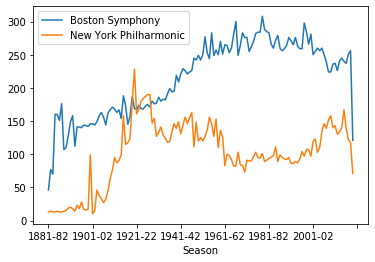

In [203]:
#plt.figure(figsize=(15,10))
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')

a = boston_df.groupby('Season').count()['Orchestra']
b = newyork_df.groupby('Season').count()['Orchestra']
combined = pd.merge(a, b, on='Season')
combined.columns = ['Boston Symphony','New York Philharmonic'] 
combined.plot()


#### When concerts typically are. Has day of the week changed. 

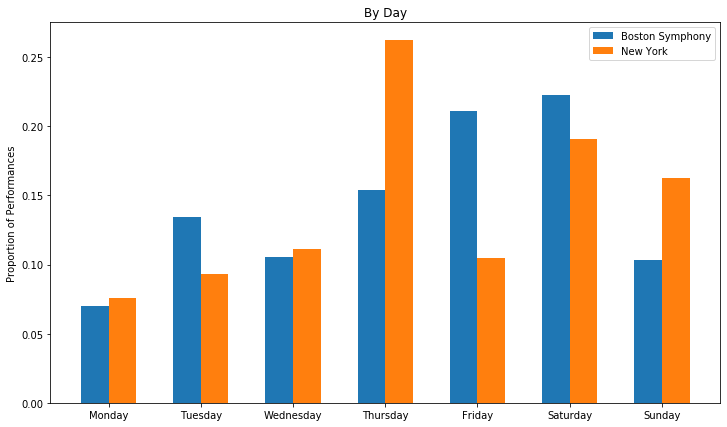

In [8]:
a = boston_df['Date'].apply(lambda x: x.weekday() + 1)
b = newyork_df['Date'].apply(lambda x: x.weekday() + 1)
a = a.groupby(a).count()/a.shape[0]
b = b.groupby(b).count()/b.shape[0]

plt.figure(figsize=(12,7))

N = 7
blue_bar = a
orange_bar = b
ind = np.arange(N)

width = 0.3       
plt.bar(ind, blue_bar , width, label='Boston Symphony')
plt.bar(ind + width, orange_bar, width, label='New York')

plt.ylabel('Proportion of Performances')
plt.title('By Day')
plt.xticks(ind + width / 2, ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.legend(loc='best')
plt.show()

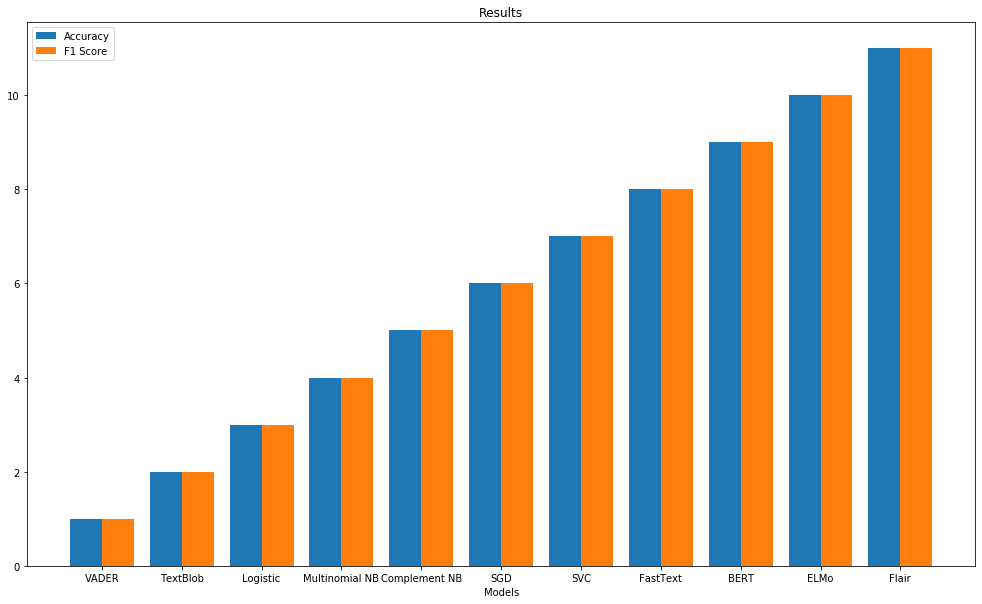

#### Timing of Concerts

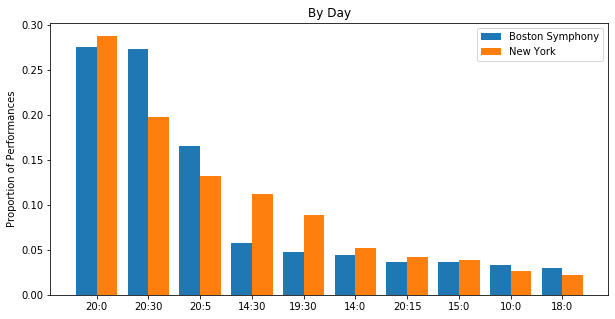

In [211]:
#Timing of concerts over the past 100 years. Time of day
a = boston_df.groupby('Time').count().sort_values(by = ['Date'], ascending = False)['Date'].head(10)
a = a.apply(lambda x: x/ a.sum())
#min(boston_df['Time'])
#max(boston_df['Time'])

b = newyork_df.groupby('Time').count().sort_values(by = ['Orchestra'], ascending = False)['Orchestra'].head(10)
b = b.apply(lambda x: x/ b.sum())
#min(newyork_df['Time'])
#max(newyork_df['Time'])

plt.figure(figsize=(10,5))

N = 10
blue_bar = a
orange_bar = b
ind = np.arange(N)

width = 0.4     
plt.bar(ind, blue_bar , width, label='Boston Symphony')
plt.bar(ind + width, orange_bar, width, label='New York')

plt.ylabel('Proportion of Performances')
plt.title('By Day')
plt.xticks(ind + width / 2, [str(i.hour) + (':') + str(i.minute) for i in a.index])

plt.legend(loc='best')
plt.show()

In [ ]:
#Specifically Boston concerts over years
#boston_df[boston_df['Orchestra'].str.contains('Boston Symphony') == True].groupby('Season').count()['Date'].plot()
#newyork_df[newyork_df['Orchestra'].str.contains('New York') == True].groupby('Season').count()['Orchestra'].plot()


#Number of pieces by season
#boston_df_flat.groupby('Season').count()['Date'].plot()
#newyork_df_flat.groupby('Season').count()['Date'].plot()

#### Number of Pieces by Concert

<Figure size 1080x720 with 0 Axes>

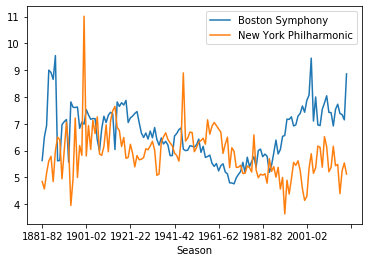

In [191]:
plt.figure(figsize=(15,10))

boston_df['pieces_num'] = boston_df['Work'].apply(lambda x: len(x))
a = boston_df.groupby('Season').mean()['pieces_num']

newyork_df['pieces_num'] = newyork_df['WorkTitle'].apply(lambda x: len(x))
b = newyork_df.groupby('Season').mean()['pieces_num']

combined = pd.merge(a, b, on='Season')
combined.columns = ['Boston Symphony','New York Philharmonic'] 
combined.plot()

del boston_df['pieces_num']
del newyork_df['pieces_num']

### Hall

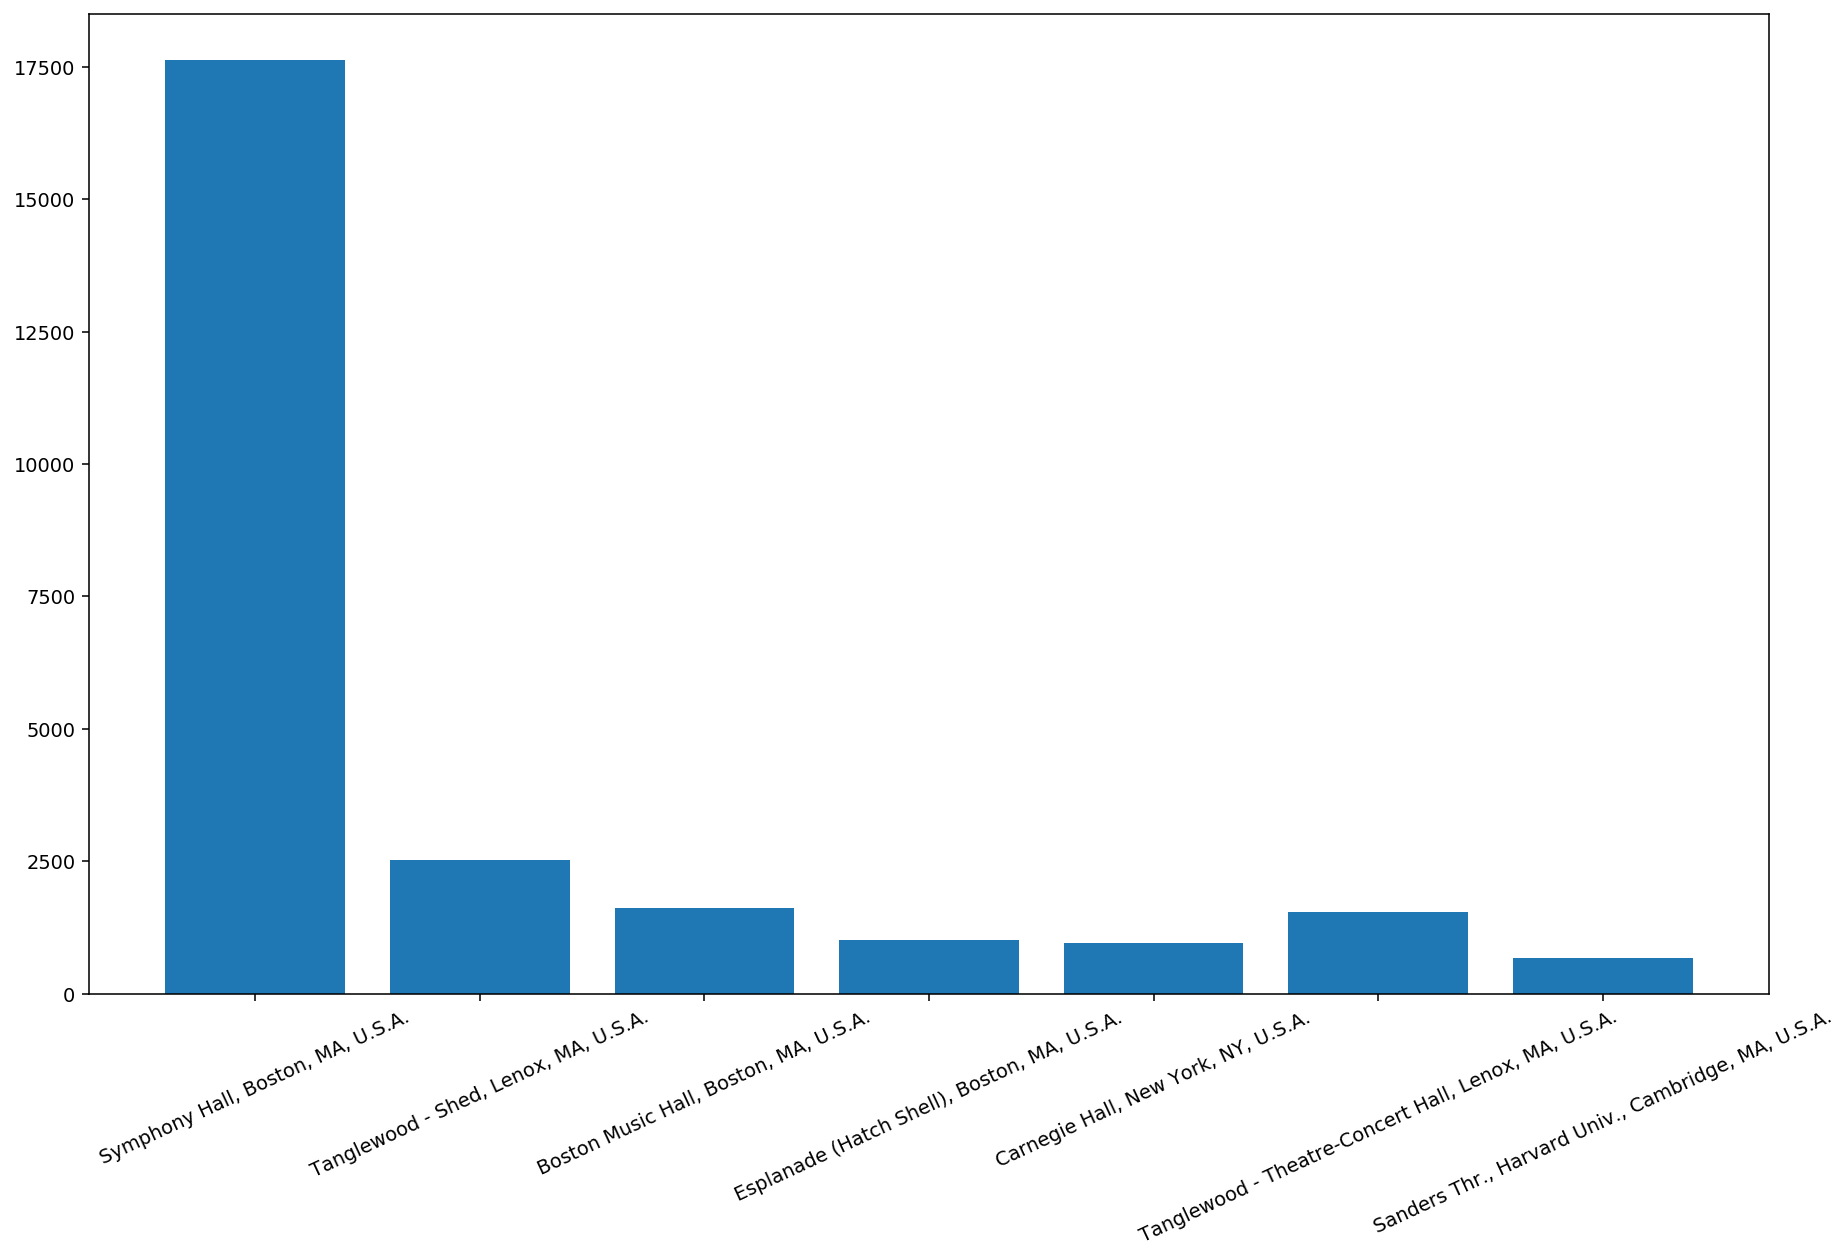

In [240]:
#General
#boston_df.groupby('Hall').count().sort_values(by=['Orchestra'], ascending = False)['Date'].head(20).plot()
#boston_df[boston_df['Hall'] == 'Symphony Hall, Boston, MA, U.S.A.']['Month'].hist()
#boston_df[boston_df['Hall'] == 'Tanglewood - Shed, Lenox, MA, U.S.A.']['Month'].hist()

a = boston_df.groupby('Hall').count().sort_values(by=['Orchestra'], ascending = False)['Date'].head(7)
fig=plt.figure(figsize=(12, 7), dpi= 140, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
langs = list(a.index)
students = a
degrees = 25
plt.xticks(rotation=degrees)
ax.bar(langs,students)
plt.show()

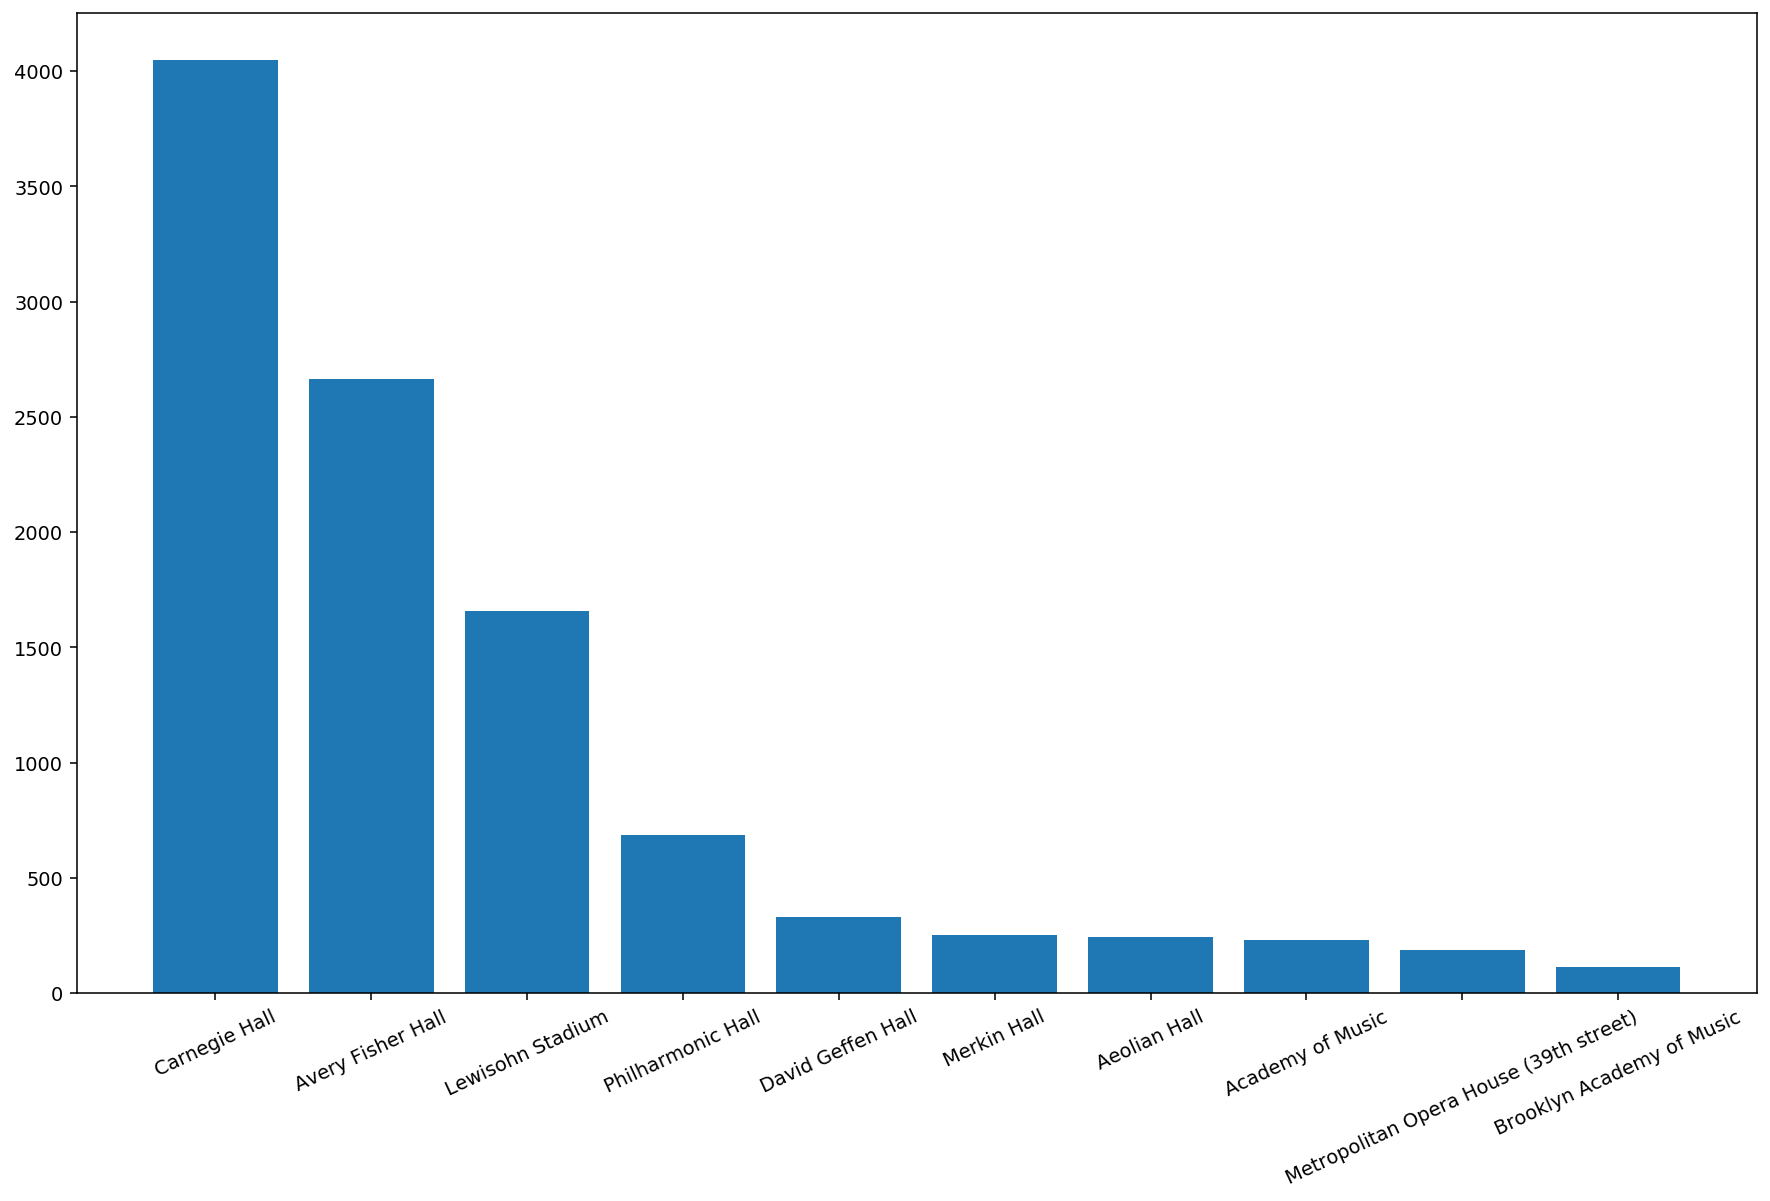

In [238]:
b = newyork_df.groupby('Hall').count().sort_values(by = ['Orchestra'], ascending = False)['Date'].head(10)
fig=plt.figure(figsize=(12, 7), dpi= 140, facecolor='w', edgecolor='k')
ax = fig.add_axes([0,0,1,1])
langs = list(b.index)
students = b
degrees = 25
plt.xticks(rotation=degrees)
ax.bar(langs,students)
plt.show()

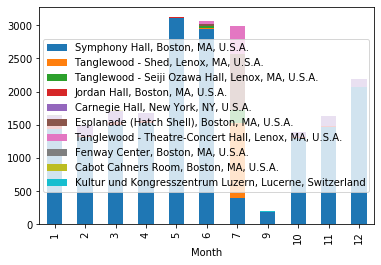

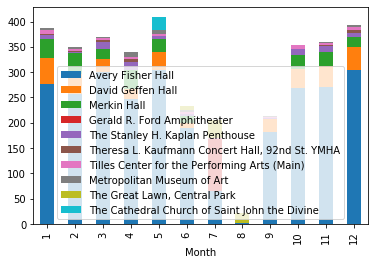

In [271]:
#Finding the monthly trend with halls of the last 120 years

a = pd.DataFrame()
popular_halls_bso = boston_df[boston_df['Year'] > 2000].groupby('Hall').count().sort_values(by = ['Orchestra'], ascending = False)['Date'].head(10).index
popular_halls_bso = pd.Series(popular_halls_bso)
for i in range(0, 10):
    a [popular_halls_bso[i]] = boston_df[boston_df['Hall'] == popular_halls_bso[i]].groupby('Month').count()['Orchestra']
a.plot(kind = 'bar', stacked = True)

b = pd.DataFrame()
popular_halls_ny = newyork_df[newyork_df['Year'] > 2000].groupby('Hall').count().sort_values(by = ['Orchestra'], ascending = False)['Date'].head(10).index
popular_halls_ny = pd.Series(popular_halls_ny)
for i in range(0, 10):
    b[popular_halls_ny[i]] = newyork_df[newyork_df['Hall'] == popular_halls_ny[i]].groupby('Month').count()['Orchestra']
b.plot(kind = 'bar', stacked = True)

In [294]:
#Tours they went on

hall_info_bso = boston_df.groupby('Hall').count().sort_values(by=['Orchestra'], ascending = False)['Orchestra']
for i in range(0, 100):
    if "U.S.A" not in hall_info_bso.index[i]:
        print(str(hall_info_bso[i]) + ' concerts at ' + hall_info_bso.index[i])
        
# a = hall_info_bso
# a = a[a.index.isin([i for i in list(hall_info_bso.index) if 'U.S.A' not in i])].head(10)
# fig=plt.figure(figsize=(12, 7), dpi= 140, facecolor='w', edgecolor='k')
# ax = fig.add_axes([0,0,1,1])
# langs = list(a.index)
# students = a
# degrees = 25
# plt.xticks(rotation=degrees)
# ax.bar(langs,students)
# plt.show()
  
    
# Filtering by USA doesn't work. 
# hall_info_ny = newyork_df.groupby('Hall').count().sort_values(by=['Orchestra'], ascending = False)['Orchestra']
# for i in range(0, 100):
#     if "U.S.A" not in hall_info_ny.index[i]:
#         print(str(hall_info_ny[i]) + ' concerts at ' + hall_info_ny.index[i])

13 concerts at Suntory Hall, Tokyo, Japan
12 concerts at Royal Albert Hall, London, United Kingdom
12 concerts at Philharmonie, Berlin, Germany
11 concerts at Usher Hall, Edinburgh (Scot.), United Kingdom
11 concerts at Osaka Festival Hall, Osaka, Japan
11 concerts at Theatre des Champs-Elysees, Paris, France
10 concerts at Gesellschaft der Musikfreunde in Wien, Grosser Musikvereinss, Vienna, Austria
9 concerts at Kultur und Kongresszentrum Luzern, Lucerne, Switzerland
9 concerts at Massey Music Hall, Toronto, Canada
9 concerts at Royal Festival Hall, London, United Kingdom
8 concerts at Grosses Festspielhaus, Salzburg, Austria
7 concerts at Hong Kong Cultural Ctr., Hong Kong, China


In [272]:
#The different halls and their popularity over the years

#Finding trend over long time 

#yearly_halls_bso = pd.DataFrame()
#for i in range(0, 11):
#    yearly_halls_bso[popular_halls_bso[i]] = boston_df[boston_df['Hall'] == popular_halls_bso[i]].groupby('Year').count()['Orchestra']
#yearly_halls_bso.plot()

yearly_halls_ny = pd.DataFrame()
for i in range(0, 11):
    yearly_halls_ny[popular_halls_ny[i]] = newyork_df[newyork_df['Hall'] == popular_halls_ny[i]].groupby('Year').count()['Orchestra']
yearly_halls_ny.plot()



#During Christmas or summer, what kind of music do we most see?

#Christmas
#boston_df_flat [boston_df_flat['Month'].isin([11,12,1])].groupby('Work').count()

pieces_ny_dic = newyork_df_flat[['WorkTitle', 'WorksID']].set_index('WorksID').to_dict()['WorkTitle']
top_pieces_christmas_ny = newyork_df_flat [newyork_df_flat['Month'].isin([11,12,1])].groupby('WorksID').count().sort_values('Orchestra', ascending = False).head(20)
top_pieces_index = pd.Series(top_pieces_christmas_ny.index).apply(lambda x: pieces_ny_dic[x])
pd.concat([top_pieces_christmas_ny['Orchestra'].reset_index(drop=True), top_pieces_index], axis=1)


#New Years
boston_df_flat [(boston_df_flat['Date'].apply(lambda x: x.month) == 1) & (boston_df_flat['Date'].apply(lambda x: x.day) == 1)].groupby('Work: Composer')
boston_df_flat [(boston_df_flat['Date'].apply(lambda x: x.month) == 1) & (boston_df_flat['Date'].apply(lambda x: x.day) == 1)].groupby('Work: Composer')

#Summer. You can just change the hall.
#boston_df [( boston_df['Date'].apply(lambda x: x.month) == 7) & ( boston_df['Date'].apply(lambda x: x.day) == 8)]




KeyError: 10

In [299]:
#What are the performming groups? - BSO

#Ocassional tours from other orchestras and stuff
groups = boston_df.groupby('Orchestra').count().sort_values(by=['Date'], ascending = False)['Date'].head(15)
print(groups)

#How much the marginal orchestras increases their performances
concerts = (1 - sum(groups[0:4])/sum(groups))*100
str(round(concerts, 2)) + '% of the concerts are not from BSO'

Orchestra
Boston Symphony Orchestra                               17616
Boston Pops Orchestra                                    7279
Boston Pops Esplanade Orchestra                          2155
Boston Symphony Chamber Players                           801
Tanglewood Music Center Orchestra                         531
Tanglewood Music Center Fellows                           270
Members of the Boston Symphony Orchestra                  186
TMC Chamber Orchestra Groups                               91
BSO members                                                57
TMC Opera Orchestra                                        52
Tanglewood Festival Chorus                                 45
Juilliard String Quartet                                   33
Tanglewood Music Center Faculty                            30
Emerson Str. Quartet                                       22
BSO; TMCO                                                  22
Beaux Arts Trio                                            2

'4.9% of the concerts are not from BSO'

In [302]:
#What are the performming groups? - NYP

#Ocassional tours from other orchestras and stuff
groups = newyork_df.groupby('Orchestra').count().sort_values(by=['Date'], ascending = False)['Date'].head(15)
print(groups)

#How much the marginal orchestras increases their performances
concerts = (1 - sum(groups[0:7])/sum(groups))*100
str(round(concerts, 2)) + '% of the concerts are not from NYP'

Orchestra
New York Philharmonic                       10145
Stadium-NY Philharmonic                      1735
New York Symphony                            1208
Musicians from the New York Philharmonic      551
NY Philharmonic Ensembles                     232
NYP Presentation                              202
Members of NY Philharmonic                    152
New/National Symphony Orchestra                60
Strike Orchestra (Philharmonic)                 9
Shanghai Orchestra Academy                      3
Members of NY Symphony                          2
None                                            2
Name: Date, dtype: int64


'0.53% of the concerts are not from NYP'

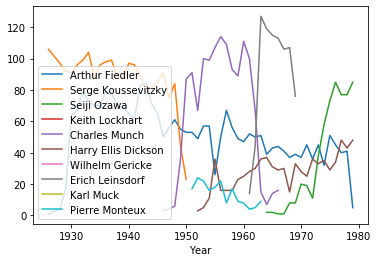

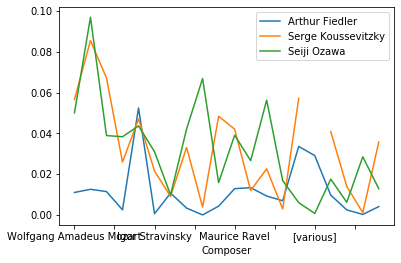

In [397]:
#Conductor

#Most popular conductor
Top_Conductors = boston_df.groupby('Conductor').count().sort_values(by=['Date'], ascending = False)['Orchestra'].head(20)
Conductors_List = pd.Series(Top_Conductors.index)
conductors_df = pd.DataFrame()

for i in range(0, 10):
    conductors_df[Conductors_List[i]] = boston_df[boston_df['Conductor'] == Conductors_List[i]].groupby('Year').count()['Orchestra']
conductors_df.plot()

#What kind of music the longest conductors performed, tours and that kind of thing.
conductors_music = pd.DataFrame()
for i in range(0, 3):
    conductors_music[Conductors_List[i]] = boston_df_flat [boston_df_flat['Conductor'] == Conductors_List[i]].groupby('Composer').count()['Orchestra']
    conductors_music[Conductors_List[i]] = conductors_music[Conductors_List[i]]/boston_df_flat[boston_df_flat['Conductor'] == Conductors_List[i]].shape[0]

Top_Composers = df1.groupby('Composer').count().sort_values(by=['Date'], ascending = False)['Orchestra'].head(20)
conductors_music = conductors_music.loc[Top_Composers.index]
conductors_music.plot()

<Figure size 2160x1440 with 0 Axes>

<Figure size 1600x960 with 0 Axes>

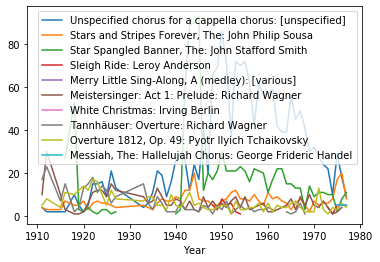

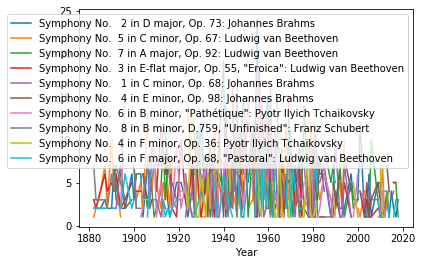

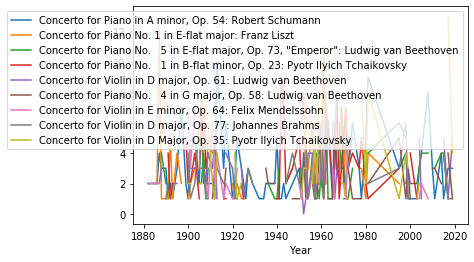

In [446]:
#Works

from matplotlib.pyplot import figure
plt.figure(figsize=(30,20))
figure(num=None, figsize=(20, 12), dpi=80, facecolor='w', edgecolor='k')

#What are the most popular works in general and tracking

boston_df_flat.groupby(['Composer', 'Work']).count().sort_values('Orchestra', ascending = False)['Orchestra'].head(15)
boston_df_flat['Work: Composer'] = boston_df_flat['Work'] + ': ' + boston_df_flat['Composer']
top_works = boston_df_flat.groupby('Work: Composer').count().sort_values('Orchestra', ascending = False)['Orchestra'].head(150)
top_works_index = pd.Series(top_works.index)
works_df = pd.DataFrame()

for i in range(0, 10):
    works_df[top_works_index.iloc[i]] = boston_df_flat [boston_df_flat['Work: Composer'] == top_works_index.iloc[i]].groupby('Year').count()['Orchestra']
works_df.plot()

top_symphonies = [work for work in top_works_index if 'Symphony' in work]
symphonies_df = pd.DataFrame()
for i in range(0, 10):
    symphonies_df[top_symphonies[i]] = boston_df_flat [boston_df_flat['Work: Composer'] == top_symphonies[i]].groupby('Year').count()['Orchestra']
symphonies_df.plot()

top_concertos = [work for work in top_works_index if 'Concerto' in work]
concertos_df = pd.DataFrame()
for i in range(0, len(top_concertos)):
    concertos_df[top_concertos[i]] = boston_df_flat [boston_df_flat['Work: Composer'] == top_concertos[i]].groupby('Year').count()['Orchestra']
concertos_df.plot()



#Monthly Seasonality

#month_df = pd.DataFrame()
#for i in range(0, 10):
#    df1 [df1 == works_index[i]]
#    month_df[works_index.iloc[i]] = df1 [df1['Work'] == works_index.iloc[i]].groupby('Month').count()['Orchestra']
#    conductorsdf[conductors1[i]] = df[df['Conductor'] == conductors1[i]].groupby('Year').count()['Orchestra']
#month_df.plot()

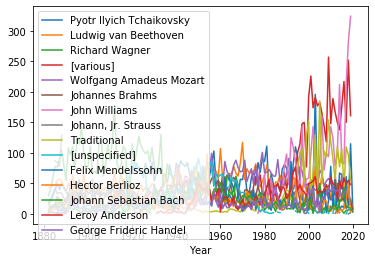

In [455]:
#Composer

top_composers = boston_df_flat.groupby('Composer').count().sort_values('Orchestra', ascending = False)['Orchestra'].head(10) 

Composers = boston_df_flat.groupby(['Composer'], as_index=False).count().sort_values('Orchestra', ascending = False).head(20)
Composers_index = pd.Series(Composers['Composer'])
Composers_df = pd.DataFrame()

for i in range(0, 15):
    Composers_df[ Composers_index.iloc[i]] = boston_df_flat [boston_df_flat['Composer'] == Composers_index.iloc[i]].groupby('Year').count()['Orchestra']
Composers_df.plot()


,Orchestra,Date,Time,Season,Hall,Conductor,Year,Month,Composer,Work
17446,Boston Symphony Orchestra,1891-10-09,NaT,1891-1892 Season,"Boston Music Hall, Boston, MA, U.S.A.",Arthur Nikisch,1891,10,Ludwig van Beethoven,"Consecration of the House: Overture, Op. 124"
17446,Boston Symphony Orchestra,1891-10-09,NaT,1891-1892 Season,"Boston Music Hall, Boston, MA, U.S.A.",Arthur Nikisch,1891,10,Ludwig van Beethoven,"Ah, Perfido!, Scene and Aria, Op. 65"
17446,Boston Symphony Orchestra,1891-10-09,NaT,1891-1892 Season,"Boston Music Hall, Boston, MA, U.S.A.",Arthur Nikisch,1891,10,Richard Wagner,Parsifal: Act 3: Good Friday Spell
17446,Boston Symphony Orchestra,1891-10-09,NaT,1891-1892 Season,"Boston Music Hall, Boston, MA, U.S.A.",Arthur Nikisch,1891,10,Richard Wagner,"Tannhäuser: Act 2: Elizabeth's Greeting, Dich,..."
17446,Boston Symphony Orchestra,1891-10-09,NaT,1891-1892 Season,"Boston Music Hall, Boston, MA, U.S.A.",Arthur Nikisch,1891,10,Robert Schumann,"Symphony No. 3 in E-flat major, Op. 97, ""Rhe..."
...,...,...,...,...,...,...,...,...,...,...
24852,Boston Pops Orchestra,1885-05-13,1900-01-01 15:00:00,1884-1885 Season,"Boston Music Hall, Boston, MA, U.S.A.",Adolf Neuendorff,1885,5,Béla Kéler,"Rákóczy Overture, Op. 76 (arr. for organ and o..."
24852,Boston Pops Orchestra,1885-05-13,1900-01-01 15:00:00,1884-1885 Season,"Boston Music Hall, Boston, MA, U.S.A.",Adolf Neuendorff,1885,5,Richard Wagner,Lohengrin: Act 1: Prelude
24852,Boston Pops Orchestra,1885-05-13,1900-01-01 15:00:00,1884-1885 Season,"Boston Music Hall, Boston, MA, U.S.A.",Adolf Neuendorff,1885,5,Richard Wagner,Lohengrin: Act 3: Prelude
24852,Boston Pops Orchestra,1885-05-13,1900-01-01 15:00:00,1884-1885 Season,"Boston Music Hall, Boston, MA, U.S.A.",Adolf Neuendorff,1885,5,Luigi Arditi,"Ingénue, La [The Ingenue]"


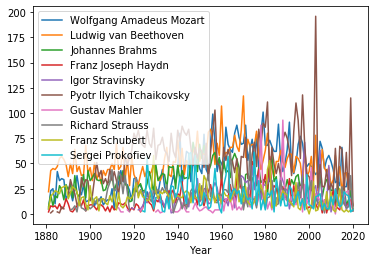

In [332]:
#Composer

top_composers = boston_df_flat.groupby('Composer').count().sort_values('Orchestra', ascending = False)['Orchestra'].head(10) 
#Most popular composers and their pieces

#boston_df_flat.groupby(['Composer', 'Year']).count().sort_values('Year')['Orchestra'].plot()
Composers = df1.groupby(['Composer'], as_index=False).count().sort_values('Orchestra', ascending = False).head(10)
Composers_index = pd.Series(Composers['Composer'])
Composers_df = pd.DataFrame()
pieces = np.array(boston_df_flat.groupby('Year').count()['Orchestra'])
dic = pd.Series(pieces,index=list(range(1881, 2021))).to_dict()

for i in range(0, 10):
    Composers_df[ Composers_index.iloc[i]] = boston_df_flat [boston_df_flat['Composer'] == Composers_index.iloc[i]].groupby('Year').count()['Orchestra']
Composers_df.plot()


#boston_df_flat['Pieces_in_Year'] = df['Year']


#Composers who were popular before and not now
#Composers who were not popular before but are now




In [344]:
#l= []
#for i in range(1844, 1846):
#    link = ('https://archives.nyphil.org/performancehistory/#program?npp:Date=[' + str(i) + '-1-1T00\:00\:00Z%20TO%20' + str(i + 1) + '-1-1T23\:59\:59Z]|false|false')
#    l.append(link)
#for link in l:
#    print(link)



In [396]:
ID = []
orchestra = []
programID = []
season = []
eventType = []
Location = []
Venue = []
Date = []
Time = []

WorksID = []
ComposerName = []
WorkTitle = []
ConductorName = []
Soloists = []



for row in programs:
    worksID = []
    composerName = []
    workTitle = []
    conductorName = []
    soloists = []
    
    for work in row['works']:
        worksID.append(work['ID'])
        
        try:
            composerName.append(work['composerName'])
        except:
            composerName.append('NA')

        try:
            workTitle.append(work['workTitle'])
        except:
            workTitle.append('NA')
            
        try:
            conductorName.append(work['conductorName'])
        except:
            conductorName.append('No Conductor')
            
        try:
            soloists.append(work['soloists'])
        except:
            soloists.append('No Soloists')

            
    WorksID.append(worksID)
    ComposerName.append(composerName)
    WorkTitle.append(workTitle)
    ConductorName.append(conductorName)
    Soloists.append(soloists)
    
    
    ID.append(row['id'])
    programID.append(row['programID'])
    season.append(row['season'])
    orchestra.append(row['orchestra'])
    eventType.append(row['concerts'][0]['eventType'])
    Location.append(row['concerts'][0]['Location'])
    Venue.append(row['concerts'][0]['Venue'])
    Date.append(row['concerts'][0]['Date'])
    Time.append(row['concerts'][0]['Time'])
    
data = {'orchestra': orchestra, 
        'programID':programID, 
        'season': season, 
        'Location':Location, 
        'eventType': eventType, 
        'Venue': Venue, 
        'Date': Date, 
        'Time': Time, 
        'WorksID': WorksID, 
        'composerName': ComposerName,
        'WorkTitle': WorkTitle,
        'conductorName': ConductorName,
        'Soloists': Soloists
       } 



newyork_df = pd.DataFrame(data, index = ID)

#Converting into Date Fromat
#newyork_df['Date'] = pd.to_datetime(newyork_df['Date'][0:9], format = "%Y-%m-%d")

newyork_df['Date'] = pd.to_datetime(newyork_df['Date'], format = "%Y-%m-%dT%I:%M:%SZ")
newyork_df['Year'] = newyork_df['Date'].apply(lambda x: x.year)
newyork_df['Month'] = newyork_df['Date'].apply(lambda x: x.month)

def convert_time(x):
    try:
        return datetime.datetime.strptime(x, '%I:%M%p')
    except:
        return None
    
newyork_df['Time'] = newyork_df['Time'].apply(convert_time)

    
#sample = newyork_df.apply(convert_time)
#newyork_df['Sample'] = pd.to_datetime( (str(newyork_df['Date']) + '' + str(newyork_df['Time'])), '%Y-%m-%dT05:00:00Z%I:%M%p')
#newyork_df.apply(lambda r : pd.datetime.combine(r['Date'],r['Time']).time(),1)    
#newyork_df['Time'] = newyork_df.apply(convert_time)


newyork_df

,orchestra,programID,season,Location,eventType,Venue,Date,Time,WorksID,composerName,WorkTitle,conductorName,Soloists,Year,Month
00646b9f-fec7-4ffb-9fb1-faae410bd9dc-0.1,New York Philharmonic,3853,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,1900-01-01 20:00:00,"[52446*, 8834*4, 3642*, 0*, 8834*3, 8835*1, 88...","[Beethoven, Ludwig van, Weber, Carl Maria ...","[SYMPHONY NO. 5 IN C MINOR, OP.67, OBERON, QUI...","[Hill, Ureli Corelli, Timm, Henry C., No Condu...","[[], [{'soloistName': 'Otto, Antoinette', 'sol...",1842,12
1118e84e-eb59-46cc-9119-d903375e65e6-0.1,New York Philharmonic,5178,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1843-02-18 05:00:00,1900-01-01 20:00:00,"[52437*, 8838*2, 3659*, 0*, 8839*2, 53076*2, 5...","[Beethoven, Ludwig van, Bellini, Vincenzo, ...","[SYMPHONY NO. 3 IN E FLAT MAJOR, OP. 55 (EROIC...","[Hill, Ureli Corelli, Hill, Ureli Corelli, Hil...","[[], [{'soloistName': 'Otto, Antoinette', 'sol...",1843,2
08536612-27c3-437e-9b44-def21034b06c-0.1,Musicians from the New York Philharmonic,10785,1842-43,"Manhattan, NY",Special,Apollo Rooms,1843-04-07 05:00:00,1900-01-01 20:00:00,"[52364*1, 8834*4, 4567*, 5150*, 5161*, 5162*2,...","[Beethoven, Ludwig van, Weber, Carl Maria ...","[EGMONT, OP.84, OBERON, CONCERTO, PIANO, A MIN...","[Hill, Ureli Corelli, Not conducted, Hill, Ure...","[[], [{'soloistName': 'Otto, Antoinette', 'sol...",1843,4
81a3b8de-1737-4c9e-9318-b839f7c7c4c0-0.1,New York Philharmonic,5887,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1843-04-22 05:00:00,1900-01-01 20:00:00,"[52434*, 3666*, 5801*1, 0*, 52425*, 3674*, 507...","[Beethoven, Ludwig van, Haydn, Franz Josep...","[SYMPHONY NO. 2 IN D MAJOR, OP.36, SYMPATHY, H...","[Boucher, Alfred, Loder, George, Loder, George...","[[], [{'soloistName': 'Loder, Edward', 'solois...",1843,4
09581bb7-8855-4965-b302-fc54cc669041-0.1,New York Philharmonic,305,1843-44,"Manhattan, NY",Subscription Season,Apollo Rooms,1843-11-18 05:00:00,NaT,"[52453*, 3677*1, 0*, 8955*1, 5190*3, 50729*]","[Beethoven, Ludwig van, Nini, Alessandro, N...","[SYMPHONY NO. 7 IN A MAJOR, OP.92, IDA DELLA T...","[Hill, Ureli Corelli, Hill, Ureli Corelli, No ...","[[], [{'soloistName': 'Castellan, Jeanne Anais...",1843,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42b489de-e650-4218-8016-255a0503db27-0.1,New York Philharmonic,14378,2019-20,"Manhattan, NY",Subscription Season,David Geffen Hall,2020-02-27 05:00:00,1900-01-01 19:30:00,"[12704*, 0*, 51962*]","[Widmann, Jorg [Jörg], NA, Strauss, Richard]","[BABYLON SUITE, NA, SYMPHONIA DOMESTICA, OP. 53]","[Welser-Möst, Franz, No Conductor, Welser-Möst...","[[], [], []]",2020,2
a6463e99-bee1-4f6a-83ae-9fe8cdca7841-0.1,Musicians from the New York Philharmonic,14581,2019-20,"Manhattan, NY",Chamber Concert (Private),None,2020-03-02 05:00:00,1900-01-01 19:00:00,[8124*],"[Beethoven, Ludwig van]","[TRIO, VLN/VC/PNO, OP. 70, NO. 1, D MAJOR (GHO...",[No Conductor],"[[{'soloistName': 'Staples, Sheryl', 'soloistI...",2020,3
a46762dd-965d-495c-9237-2d31defef578-0.1,NYP Presentation,14582,2019-20,"Manhattan, NY",Artist in Residence / Soloist Recital,Alice Tully Hall,2020-03-03 05:00:00,1900-01-01 19:30:00,"[13168*, 8970*1, 8970*2, 8970*3, 8970*4, 8970*...","[Bach, Johann Sebastian, Bach, Johann Seba...","[PARTITA NO. 2, D MINOR, BWV 1004: CHACONNE (A...","[No Conductor, No Conductor, No Conductor, No ...","[[{'soloistName': 'Trifonov, Daniil', 'soloist...",2020,3
4c49c4bd-9a5a-4206-8cff-cdeb6bb22b15-0.1,New York Philharmonic,14380,2019-20,"Manhattan, NY",Subscription Season,David Geffen Hall,2020-03-05 05:00:00,1900-01-01 19:30:00,"[52644*, 52638*, 0*, 1490*, 53102*]","[Debussy, Claude, Debussy, Claude, NA, Ravel...",[PRELUDE A L'APRES-MIDI D'UN FAUNE (PRELUDE TO...,"[Langree [Langrée], Louis, Langree [Langrée], ...","[[], [{'soloistName': 'Juilliard Chorus', 'sol...",2020,3


In [361]:
ID = []
orchestra = []
programID = []
season = []
eventType = []
Location = []
Venue = []
Date = []
Time = []

WorksID = []
ComposerName = []
WorkTitle = []
ConductorName = []
Soloists = []

for row in programs:
    for work in row['works']:
        ID.append(row['id'])
        orchestra.append(row['orchestra'])
        programID.append(row['programID'])
        season.append(row['season'])
        Location.append(row['concerts'][0]['Location'])
        eventType.append(row['concerts'][0]['eventType'])
        Venue.append(row['concerts'][0]['Venue'])
        Date.append(row['concerts'][0]['Date'])
        Time.append(row['concerts'][0]['Time'])
        WorksID.append(work['ID'])  
        
        try:
            ComposerName.append(work['composerName'])
        except:
            ComposerName.append('No Composer')
        
        
        try:
            WorkTitle.append(work['workTitle'])
        except:
            WorkTitle.append('No Work apparently')
        
        
        try:
            ConductorName.append(work['conductorName'])
        except:
            ConductorName.append('No Conductor')
        
        
        try:
            Soloists.append(work['soloists'])
        except:
            Soloists.append('No Soloists')
        
   
data = {'orchestra': orchestra, 
        'season': season, 
        'Location':Location, 
        'eventType': eventType, 
        'Venue': Venue,
        'Date': Date,
        'Time':Time,
        'composerName': ComposerName,
        'WorkTitle': WorkTitle,
        'conductorName': ConductorName,
        'Soloists': Soloists,
        'WorksID': WorksID,
       } 
newyork_df_flat = pd.DataFrame(data, index = programID)

#Converting into Date Fromat
newyork_df_flat['Date'] = pd.to_datetime(newyork_df_flat['Date'], format = "%Y-%m-%dT%I:%M:%SZ")
newyork_df_flat['Year'] = newyork_df_flat['Date'].apply(lambda x: x.year)
newyork_df_flat['Month'] = newyork_df_flat['Date'].apply(lambda x: x.month)

newyork_df_flat

,orchestra,season,Location,eventType,Venue,Date,Time,composerName,WorkTitle,conductorName,Soloists,WorksID,Year,Month
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,"Beethoven, Ludwig van","SYMPHONY NO. 5 IN C MINOR, OP.67","Hill, Ureli Corelli",[],52446*,1842,12
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,"Weber, Carl Maria Von",OBERON,"Timm, Henry C.","[{'soloistName': 'Otto, Antoinette', 'soloistI...",8834*4,1842,12
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,"Hummel, Johann","QUINTET, PIANO, D MINOR, OP. 74",No Conductor,"[{'soloistName': 'Scharfenberg, William', 'sol...",3642*,1842,12
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,No Composer,No Work apparently,No Conductor,[],0*,1842,12
3853,New York Philharmonic,1842-43,"Manhattan, NY",Subscription Season,Apollo Rooms,1842-12-07 05:00:00,8:00PM,"Weber, Carl Maria Von",OBERON,"Etienne, Denis G.",[],8834*3,1842,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14380,New York Philharmonic,2019-20,"Manhattan, NY",Subscription Season,David Geffen Hall,2020-03-05 05:00:00,7:30PM,No Composer,No Work apparently,No Conductor,[],0*,2020,3
14380,New York Philharmonic,2019-20,"Manhattan, NY",Subscription Season,David Geffen Hall,2020-03-05 05:00:00,7:30PM,"Ravel, Maurice",SHEHERAZADE,"Langree [Langrée], Louis","[{'soloistName': 'Leonard, Isabel', 'soloistIn...",1490*,2020,3
14380,New York Philharmonic,2019-20,"Manhattan, NY",Subscription Season,David Geffen Hall,2020-03-05 05:00:00,7:30PM,"Scriabin, Alexander","SYMPHONY NO. 4, ""LE POEME D'EXTASE,"" OP. 54","Langree [Langrée], Louis",[],53102*,2020,3
14379,New York Philharmonic,2019-20,"Manhattan, NY",Fundraising Concert,David Geffen Hall,2020-03-07 05:00:00,11:00AM,"LeFrak, Karen",SLEEPOVER AT THE MUSEUM,"Bahl, Ankush Kumar","[{'soloistName': 'Bernstein, Jamie', 'soloistI...",12880*,2020,3


In [388]:
df.groupby('composerName').count()

,orchestra,programID,season,Location,eventType,Venue,Date,Time,WorkTitle,conductorName,Soloists,WorksID
composerName,,,,,,,,,,,,
"ACT,",2,2,2,2,2,2,2,2,2,2,2,2
"Abert, Johann Joseph",1,1,1,1,1,1,1,1,1,1,1,1
"Abing,",1,1,1,1,1,1,1,1,1,1,1,1
"Abt, Franz",4,4,4,4,4,4,4,4,4,4,4,4
"Achron, Isidor",2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
"Zorn, John",3,3,3,3,3,3,3,3,3,3,3,3
"Zuraj, Vito",1,1,1,1,1,1,1,1,1,1,1,1
"Zwilich, Ellen Taaffe",26,26,26,26,26,26,26,26,26,26,26,26


In [121]:
#Soloists:
#Number of soloists they have had versus now.
#Instrument of Soloist they have had until now
#How many concerts they have on the program versus now
#Most popular concertos versus least popular over time. 
#Concertos that grew in popularity, decreased or stayed the same
#Concertos not done very often
#Concertos by popular composers but not popular

#Orchestra
#How much the marginal orchestras increases their performances
#Ocassional tours and stuff

#Hall
#The different halls and their popularity over the years
#Tours they went on
#THe most frequently visited places and halls

#Conductor
#Most poplar conductor
#Shortest COnductor, people they never had again
#longest conductors
#What kind of music the longest conductors performed, tours and that kind of thing. 

#Composer
#Most popular composers and their pieces
#What are the least popular works by popular composers and what are the most popular
#How composers have shifted in style and tracking them over the years
#Composers who were popular before and not now
#Composers who were not popular before but are now

#Works
#What are the most popular works in general and tracking
#Popular works before but not now
#Popular works now but not before
#Crossreference NYP top with Boston Top


0       11
0       11
0       11
1       10
1       10
        ..
8148    10
8148    10
8149    10
8149    10
8149    10
Name: Month, Length: 29782, dtype: int64